In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Time and math
from time import time
from math import sqrt

# NLP library
import re, string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS

# Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

# Check Dir or Set Woring Dir
import os
print(os.getcwd())
os.chdir(r'D:\Dropbox\Manish Singh _ Data\Profile Data\Downloads\DS Exercise')

D:\Dropbox (eClerx Services Ltd.)


## Load the data into memory

In [2]:
df = pd.read_excel("DS Tweet.xlsx")

## Prepare the data for modelling

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42368 entries, 0 to 42367
Data columns (total 32 columns):
TweetPostedTime              42368 non-null object
TweetID                      42368 non-null int64
TweetBody                    42368 non-null object
TweetRetweetFlag             42368 non-null bool
TweetSource                  42368 non-null object
TweetInReplyToStatusID       101 non-null float64
TweetInReplyToUserID         189 non-null float64
TweetInReplyToScreenName     189 non-null object
TweetRetweetCount            42368 non-null int64
TweetFavoritesCount          42368 non-null int64
TweetHashtags                42268 non-null object
TweetPlaceID                 1000 non-null object
TweetPlaceName               1000 non-null object
TweetPlaceFullName           1000 non-null object
TweetCountry                 999 non-null object
TweetPlaceBoundingBox        1000 non-null object
TweetPlaceAttributes         0 non-null float64
TweetPlaceContainedWithin    0 non-null fl

In [4]:
# Columns to Drop
colsToDrop=['TweetID','TweetSource','TweetPostedTime', 'TweetPlaceID','TweetPlaceAttributes','TweetPlaceContainedWithin', 
            'UserID','UserDescription','UserLink', 'UserExpandedLink','UserListedCount','tweet.place',
            'TweetInReplyToStatusID','TweetInReplyToUserID','TweetInReplyToScreenName','TweetPlaceName',
            'TweetPlaceFullName','TweetCountry','TweetPlaceBoundingBox']

In [5]:
df_ = df.drop(colsToDrop,axis=1)

* del df drop old df to release memory

In [6]:
print(df_.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42368 entries, 0 to 42367
Data columns (total 13 columns):
TweetBody               42368 non-null object
TweetRetweetFlag        42368 non-null bool
TweetRetweetCount       42368 non-null int64
TweetFavoritesCount     42368 non-null int64
TweetHashtags           42268 non-null object
UserName                42368 non-null object
UserScreenName          42368 non-null object
UserLocation            26342 non-null object
UserFollowersCount      42368 non-null int64
UserFriendsCount        42368 non-null int64
UserSignupDate          42368 non-null object
UserTweetCount          42368 non-null int64
MacroIterationNumber    42368 non-null int64
dtypes: bool(1), int64(6), object(6)
memory usage: 3.9+ MB
None


In [7]:
#Converting TweetRetweetFlag to integer
df_['TweetRetweetFlag'] = df_['TweetRetweetFlag'].map({True:1,False:0})

In [8]:
df_['TweetRetweetFlag'].value_counts()

1    26862
0    15506
Name: TweetRetweetFlag, dtype: int64

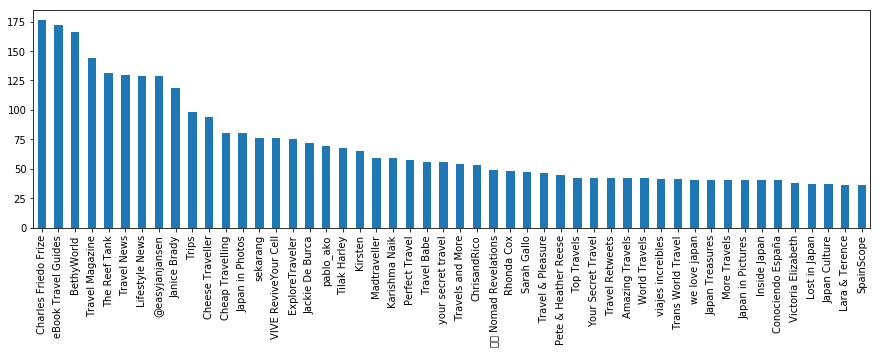

In [9]:
plt.figure(figsize=(15,4))
df_['UserName'].value_counts()[:50].plot(kind='bar')

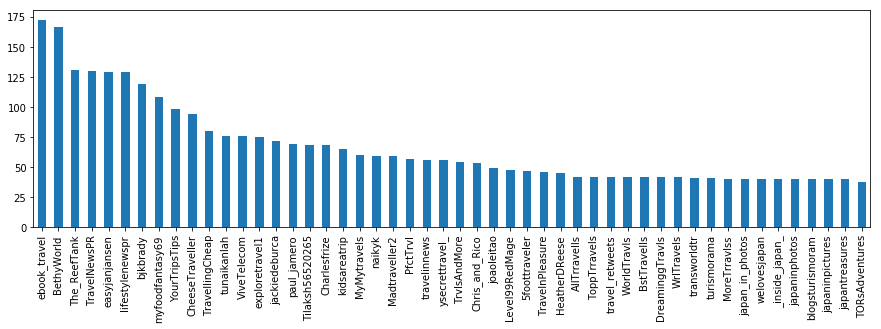

In [10]:
plt.figure(figsize=(15,4))
df_['UserScreenName'].value_counts()[:50].plot(kind='bar')

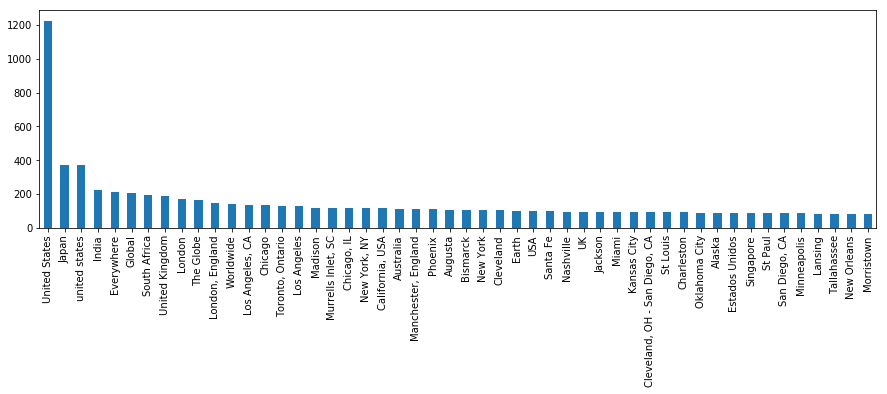

In [11]:
plt.figure(figsize=(15,4))
df_['UserLocation'].value_counts()[:50].plot(kind='bar')
# sns.distplot(df_['UserLocation'].value_counts(),bins=20) # high no. of tweets form very few location

In [12]:
# Cleaning Country attribute
country = {'united states':'united states of america','uk': 'united kingdom','california': 'california','chicago': 
           'chicago','new york city':'new york', 'ny':'new york',
           'us':'united states of america', 'india': 'india','los angeles': 'los angeles', 'london': 'london'}

In [13]:
df_['UserLocation'] =df_['UserLocation'].str.lower()
df_['UserLocation'].replace(country,inplace=True)

In [14]:
# Extract year and month from date
df_['month_of_signup'] = df_['UserSignupDate'].apply(lambda x: x.split(" ")[1])
df_['year_of_signup'] = df_['UserSignupDate'].apply(lambda x: x.split(" ")[-1])
df_.drop(columns='UserSignupDate',inplace=True,axis=1)

In [15]:
# Create Dummy for Categorical Values
df_['UserName'] = pd.factorize(df_['UserName'])[0]
df_['UserScreenName'] = pd.factorize(df_['UserScreenName'])[0]
df_['UserLocation'] = pd.factorize(df_['UserLocation'])[0]
df_['month_of_signup'] = pd.factorize(df_['month_of_signup'])[0]
df_['year_of_signup'] = pd.factorize(df_['year_of_signup'])[0]

In [16]:
# Text Cleaning
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', input_text)
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)

    def remove_digits(self, input_text):
        return re.sub('\d+', '', input_text)
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        #stopwords_list = st_words
        stopwords_list=STOPWORDS
        # Some words which might indicate a certain sentiment are kept via a whitelist        
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 1] 
        return " ".join(clean_words) 
    
    def stemming(self, input_text):
        porter = PorterStemmer()
        words = input_text.split() 
        stemmed_words = [porter.stem(word) for word in words]
        return " ".join(stemmed_words)
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.stemming)        
        return clean_X

In [17]:
ct = CleanText()
df_['TweetBody'] = ct.fit_transform(df_.TweetBody)
df_.loc[df_['TweetBody'] == '','TweetBody'] = '[no text]'

In [18]:
df_.drop(columns='TweetHashtags',axis=1,inplace=True)

In [19]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42368 entries, 0 to 42367
Data columns (total 13 columns):
TweetBody               42368 non-null object
TweetRetweetFlag        42368 non-null int64
TweetRetweetCount       42368 non-null int64
TweetFavoritesCount     42368 non-null int64
UserName                42368 non-null int64
UserScreenName          42368 non-null int64
UserLocation            42368 non-null int64
UserFollowersCount      42368 non-null int64
UserFriendsCount        42368 non-null int64
UserTweetCount          42368 non-null int64
MacroIterationNumber    42368 non-null int64
month_of_signup         42368 non-null int64
year_of_signup          42368 non-null int64
dtypes: int64(12), object(1)
memory usage: 4.2+ MB


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(min_df=10) 
vectorizer = tf_idf.fit_transform(df_['TweetBody'])

In [21]:
vectorizer

<42368x2714 sparse matrix of type '<class 'numpy.float64'>'
	with 382647 stored elements in Compressed Sparse Row format>

In [22]:
df_= pd.concat([df_,pd.DataFrame(vectorizer.toarray(), columns=tf_idf.get_feature_names())],axis=1)

## Build a model on training data

In [23]:
X= df_.drop(['TweetRetweetCount'],axis=1) # independent
y= df_['TweetRetweetCount'] # Target 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=101,shuffle=True)

In [25]:
print('X_train.shape %s, X_test.shape %s\ny_train.shape %s, y_test.shape %s'%(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train.shape (27539, 2725), X_test.shape (14829, 2725)
y_train.shape (27539,), y_test.shape (14829,)


In [26]:
# Dimension Reduction Using Truncated Singular Value Decompositions (Linear Algebra SVD)
n_components = 1000
tsvd = TruncatedSVD(n_components)
X_traindata = tsvd.fit_transform(X_train)
X_testdata = tsvd.transform(X_test)

In [29]:
lr = LinearRegression().fit(X_traindata,y_train)

## Test the model on testing data

In [30]:
y_pred = lr.predict(X_testdata)

## Provide some measure of performance

In [31]:
lr_score = r2_score(y_pred=y_pred, y_true=y_test) 
print("Variance score (r2_score): %f"%lr_score)
print('Model accuracy:%.2f '%(lr_score*100))

print("Root mean squared error of test:%f"%sqrt(mean_squared_error(y_test, y_pred)))

Variance score (r2_score): 0.997171
Model accuracy:99.72 
Root mean squared error of test:75.992302


* _R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model_ Aslo know as Coefficent of Determination
* _Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors)_

## End ..